In [252]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [597]:
#Load files
dem = pd.read_csv('states_demographics.csv')
unemp = pd.read_csv('unemployment_2016_2020.csv')
date = pd.read_csv('date.csv')

In [598]:
dem.head()

,State,effective_date,order_in_place,pop_2020,pop_growth,pop_density,perc_male_pop,median_age_pop,gdp_pc,perc_high_school,perc_bachelors,perc_advanced_degree,billions_state_local_spending
0,Alabama,4/4/20,1,4908621,0.0042,96.9221,0.48,39.2,47735,0.853,0.245,0.091,54.0
1,Alaska,3/28/20,1,734002,-0.0047,1.2863,0.51,34.6,76220,0.924,0.290,0.104,18.0
2,Arizona,3/31/20,1,7378494,0.0288,64.9550,0.49,37.9,51179,0.821,0.284,0.107,66.7
3,Arkansas,NaN,0,3038999,0.0084,58.4030,0.49,38.3,44808,0.856,0.220,0.079,27.3
4,California,3/19/20,1,39937489,0.0096,256.3727,0.49,36.8,80563,0.825,0.326,0.122,623.4


In [599]:
unemp.head()

,State,Filed week ended,Initial Claims,Reflecting Week Ended,Continued Claims,Covered Employment,Insured Unemployment Rate
0,Alabama,1/6/18,"7,534",12/30/17,"25,295","1,872,646",1.35
1,Alabama,1/13/18,"4,387",1/6/18,"21,752","1,872,646",1.16
2,Alabama,1/20/18,"2,701",1/13/18,"19,083","1,872,646",1.02
3,Alabama,1/27/18,"3,134",1/20/18,"18,672","1,872,646",1.00
4,Alabama,2/3/18,"2,455",1/27/18,"17,600","1,872,646",0.94


In [600]:
date.head()

,State,effective_date,order_in_place
0,Alabama,2020-04-04,1
1,Alaska,2020-03-28,1
2,Arizona,2020-03-31,1
3,Arkansas,NaN,0
4,California,2020-03-19,1


In [601]:
date.fillna(value='2010/01/01',inplace=True)

In [602]:
#Drop unnecessary columns
unemp.drop(['Reflecting Week Ended', 'Continued Claims', 'Covered Employment', 'Insured Unemployment Rate',], axis=1, inplace = True)
date.drop(['order_in_place'],axis = 1, inplace = True)
#Remove the comma in numbers
unemp[['Initial Claims']] = unemp[['Initial Claims']].apply(lambda x: x.str.replace(',','').apply(pd.to_numeric))
#Rename columns
unemp.rename(columns={'Initial Claims':'initial_claims', 'Filed week ended': 'filed_week_ended'}, inplace=True)



In [603]:
#Merge unemployment filings with the effective dates of stay at home orders
unemp = unemp.merge(date, how = 'right', left_on = 'State', right_on = 'State')
#fill nan in date dataframe with a very early date in order to keep the record
#convert date from string to date time
unemp[['filed_week_ended']] = unemp[['filed_week_ended']].apply(pd.to_datetime)
unemp[['effective_date']] = unemp[['effective_date']].apply(pd.to_datetime)


In [604]:
#Filter to get the records after the stay at home orders
unemp = unemp.loc[(unemp['filed_week_ended'] >= unemp['effective_date']),:]
#Get the weekly average unemployment claims
unemp = unemp[['State','initial_claims']].groupby('State').mean().reset_index()

In [605]:
#Get demographic features
dem = dem[['State','order_in_place','pop_2020','pop_growth','pop_density','perc_male_pop','median_age_pop','gdp_pc','perc_high_school','perc_bachelors','perc_advanced_degree']]
#Drop those ambiguous states that are not fully implementing stay-at-home order
dem = dem.loc[~dem['State'].isin(['Wyoming','Utah','Oklahoma']),:]



In [606]:
#Merge umployment filings with demographic factors
data = unemp.merge(dem, how = 'inner', left_on = 'State', right_on ='State')

In [613]:
#Calculate number of claims per 10,000 persons
data['claims_per_capita'] = data['initial_claims'] * 10000 /data['pop_2020']

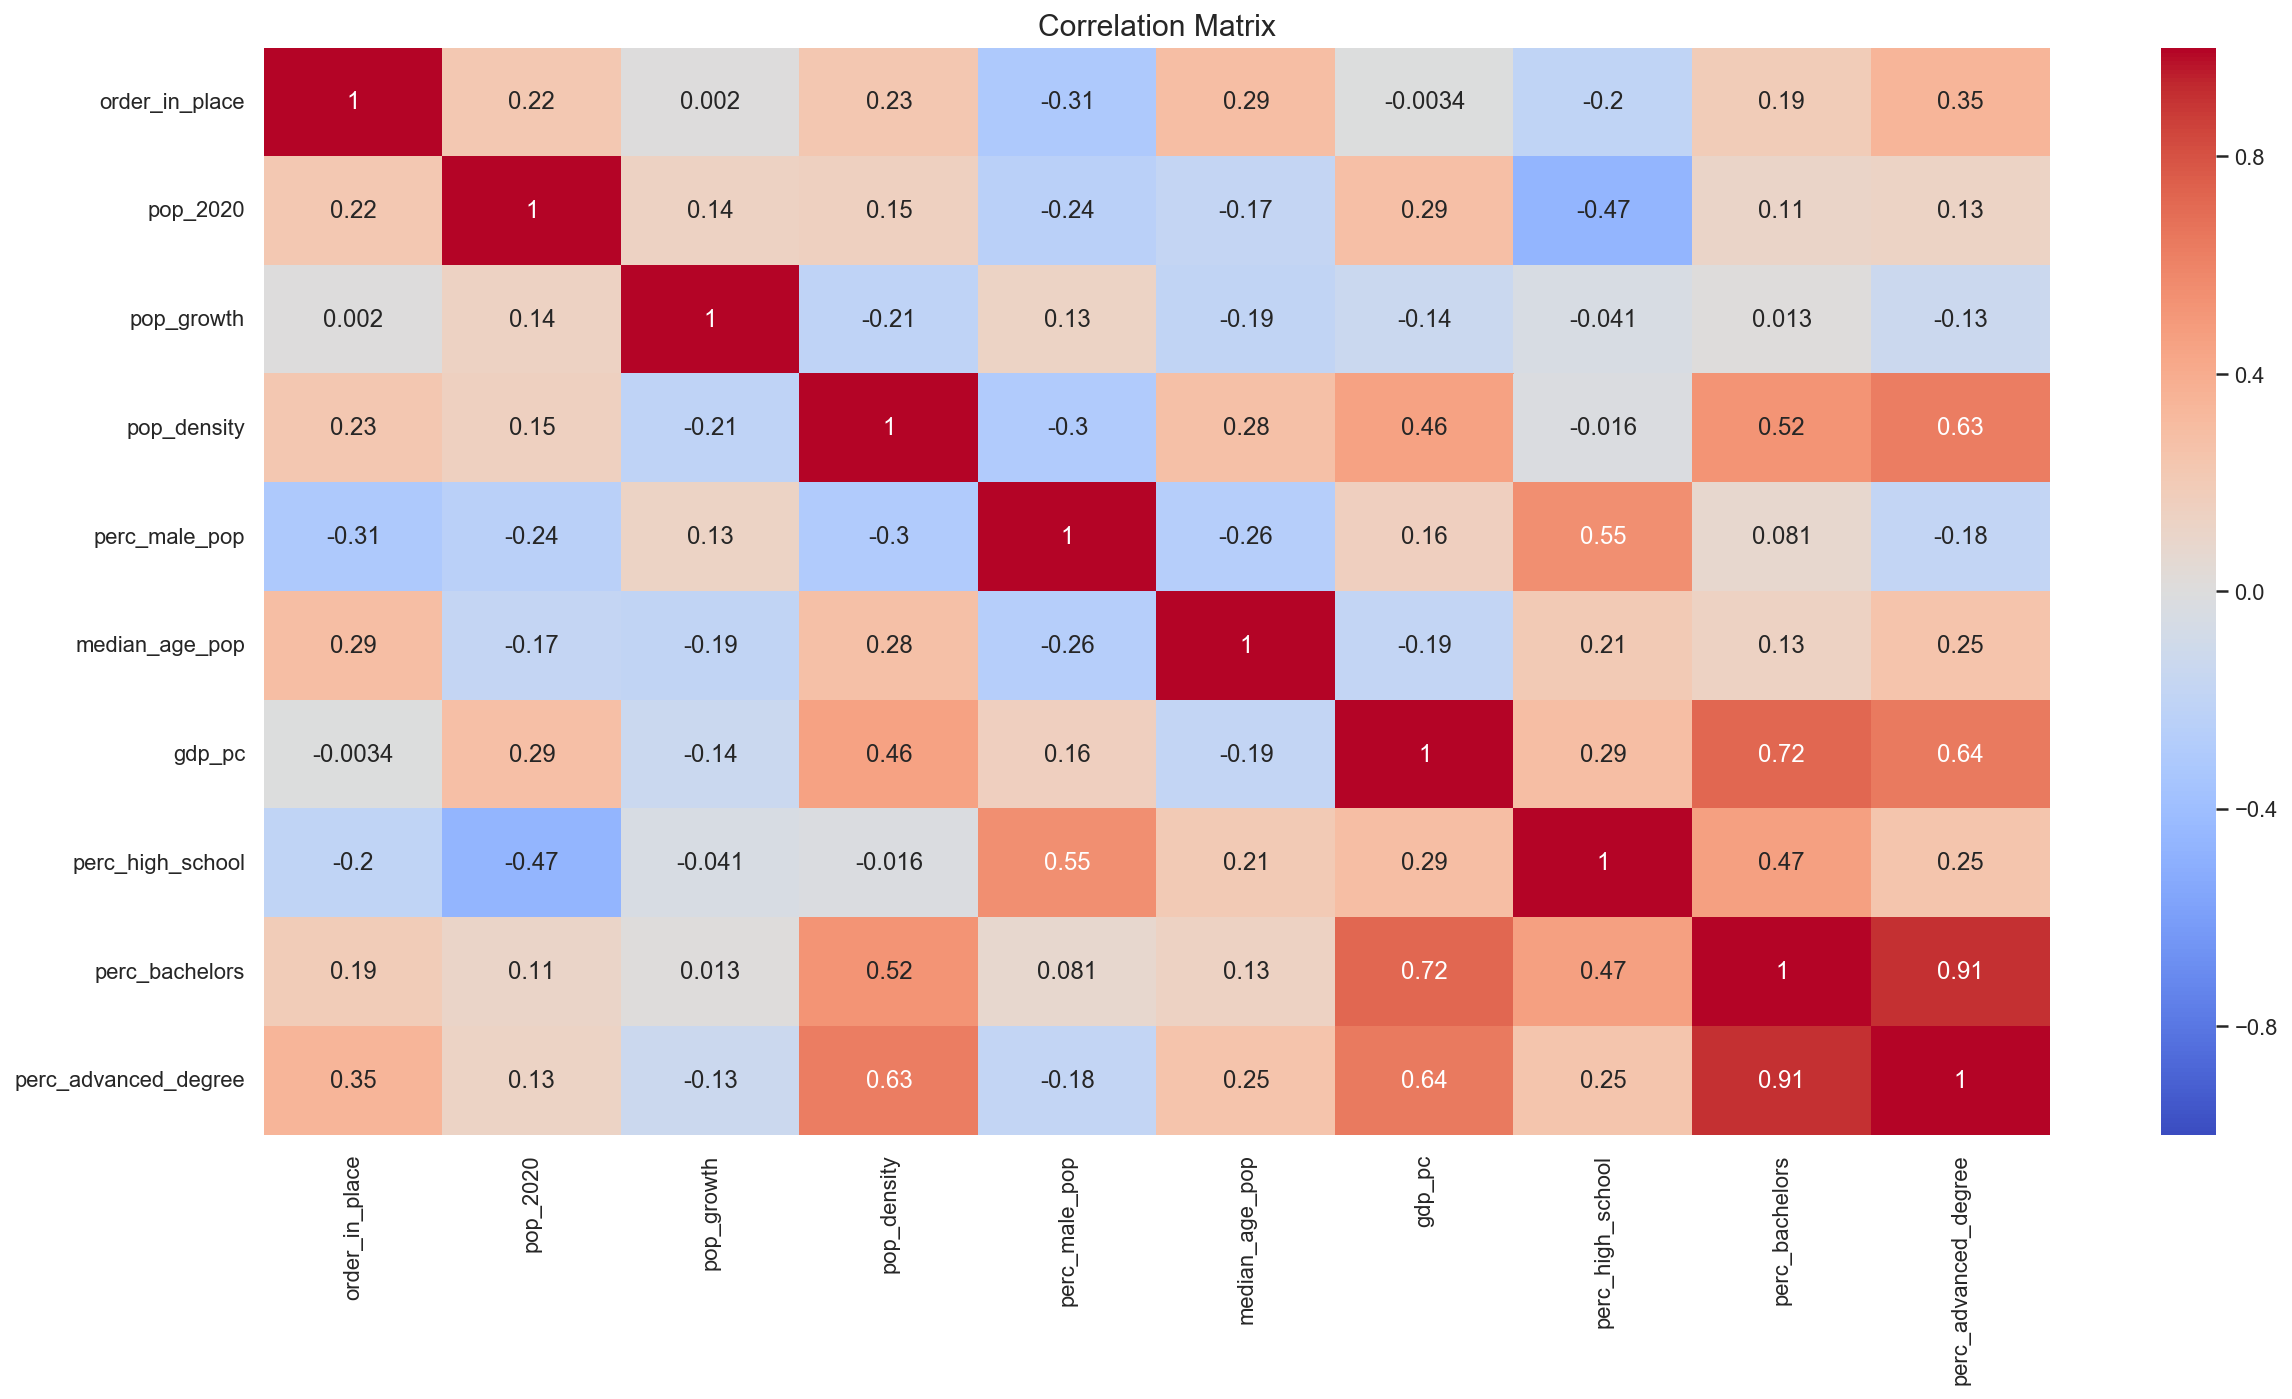

In [615]:
#Draw correlation matrix and check correlation
fig=plt.figure(figsize=(20,10))
sns.set(font_scale=1)
a = sns.heatmap(data.drop(['State', 'initial_claims', 'claims_per_capita'], axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
a.set_yticklabels(data.drop(['State','initial_claims', 'claims_per_capita'], axis=1).columns, va='center', rotation = 360)
a.set_xticklabels(data.drop(['State','initial_claims', 'claims_per_capita'], axis=1).columns, rotation = 90)
plt.title('Correlation Matrix', size=15)
plt.show()

Precentage of people holding advanced degree is highly correlated with percentage of people holding bachelor degree, so we will drop 'perc_advanced_degree' when performing regression.

In [616]:
smf.ols('claims_per_capita ~ C(order_in_place) + pop_2020 + pop_growth + pop_density + perc_male_pop + median_age_pop + gdp_pc + perc_high_school + perc_bachelors', data = data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      claims_per_capita   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     2.368
Date:                Sat, 25 Apr 2020   Prob (F-statistic):             0.0316
Time:                        21:44:43   Log-Likelihood:                -258.54
No. Observations:                  47   AIC:                             537.1
Df Residuals:                      37   BIC:                             555.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 63.0723    779.277      0.081      0.936   -1515.892    1642.037
C(order_in_place)[T.1]   155.2829     37.061      4.190      0.000      80.191     230.375
pop_2020               -2.047e-06   1.78e-06     -1.148      0.258   -5.66e-06    1.57e-06
pop_growth              -229.6736    864.837     -0.266      0.792   -1982.001    1522.653
pop_density                0.0048      0.052      0.092      0.927      -0.100       0.110
perc_male_pop            -53.4265   1755.986     -0.030      0.976   -3611.392    3504.539
median_age_pop            -2.8270      6.523     -0.433      0.667     -16.043      10.389
gdp_pc                     0.0014      0.002      0.872      0.389      -0.002       0.005
perc_high_school          76.8708    630.227      0.122      0.904   -1200.091    1353.832
perc_bachelors          -148.5209    379.288     -0.392      0.698    -917.031     619.989
==============================================================================
Omnibus:                        5.365   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                4.466
Skew:                           0.509   Prob(JB):                        0.107
Kurtosis:                       4.116   Cond. No.                     2.00e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see, the order_in_place variable is significant with a very small p-value. Holding everything else constant, the states with stay-at-home order has 155 weekly unemployment filings per 10,000 persons more than those without stay-at-home order.